# Restaurants in New York

This notebook was created after seeing:
- https://www.reddit.com/r/dataisbeautiful/comments/g5qxqb/oc_the_most_common_restaurant_cuisine_by_zipcode/
    - Complaints that the author mislead the users by grouping certain cousines together, so I was interested which cuisines were really winning!
- https://twitter.com/knaaptime/status/1252679014726025216?s=20
    - I wanted to test Tobler and the use of it to create different kind of maps
    - Explore the bias of zip codes and other geospatial features we often use

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

# Load in New York Restaurant Data

In [2]:
# Source: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
df = pd.read_csv("data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
df["ZIPCODE"] = df["ZIPCODE"].astype("Int32").astype("str")

In [3]:
df.head(2)

CAMIS         DBA           BORO BUILDING         STREET ZIPCODE  \
0  50065815  'WICHCRAFT      Manhattan     1407       BROADWAY   10018   
1  41257749     POPEYES  Staten Island     1351  FOREST AVENUE   10302   

        PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0  7184500886          Sandwiches      09/17/2018   
1  7187201545             Chicken      09/19/2018   

                                            ACTION  ... RECORD DATE  \
0  Violations were cited in the following area(s).  ...  04/21/2020   
1  Violations were cited in the following area(s).  ...  04/21/2020   

                         INSPECTION TYPE   Latitude  Longitude  \
0  Cycle Inspection / Initial Inspection  40.753432 -73.987151   
1  Cycle Inspection / Initial Inspection  40.625950 -74.134450   

  Community Board Council District Census Tract        BIN           BBL   NTA  
0           105.0              3.0      11300.0  1015265.0  1.008140e+09  MN17  
1           501.0             49.0      20100.0  5024915.0  5.010520e+09  SI07  

[2 rows x 26 columns]

# Load in zip codes of New York

In [4]:
zip_codes = gpd.read_file("data/zip_codes")
zip_codes = zip_codes.to_crs(epsg=4326)
zip_codes.head(2)

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((-73.80585 40.68291, -73.80569 40.682...  
1  POLYGON ((-73.93740 40.67973, -73.93487 40.679...

# Find out the winning cuisines for each zipcode area

In [5]:
list_cuisines_zip = df.groupby("ZIPCODE")["CUISINE DESCRIPTION"].value_counts().index.tolist()

In [6]:
list_cuisines_zip = df.groupby("ZIPCODE")["CUISINE DESCRIPTION"].value_counts(ascending=False).index.tolist()
list_cuisines_zip = pd.DataFrame(list_cuisines_zip).drop_duplicates(subset = 0) # dirty hack to only take the first value
list_cuisines_zip = list_cuisines_zip.rename(columns = {0: "ZIPCODE", 1 : "Cuisine"})

In [7]:
zip_codes_merged = gpd.GeoDataFrame(pd.merge(zip_codes, list_cuisines_zip, on='ZIPCODE'))

In [8]:
zip_codes_merged.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry    Cuisine  
0  POLYGON ((-73.80585 40.68291, -73.80569 40.682...   American  
1  POLYGON ((-73.93740 40.67973, -73.93487 40.679...  Caribbean  
2  POLYGON ((-73.90294 40.67084, -73.90223 40.668...  Caribbean  
3  POLYGON ((-73.95797 40.67066, -73.95576 40.670...  Caribbean  
4  POLYGON ((-73.97208 40.65060, -73.97192 40.650...   American

In [15]:
zip_codes_merged.crs = {'init' :'epsg:4326'}
zip_codes_merged = zip_codes_merged.to_crs(epsg=3857)

C:\Users\Kevin\Anaconda3\envs\geodata\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


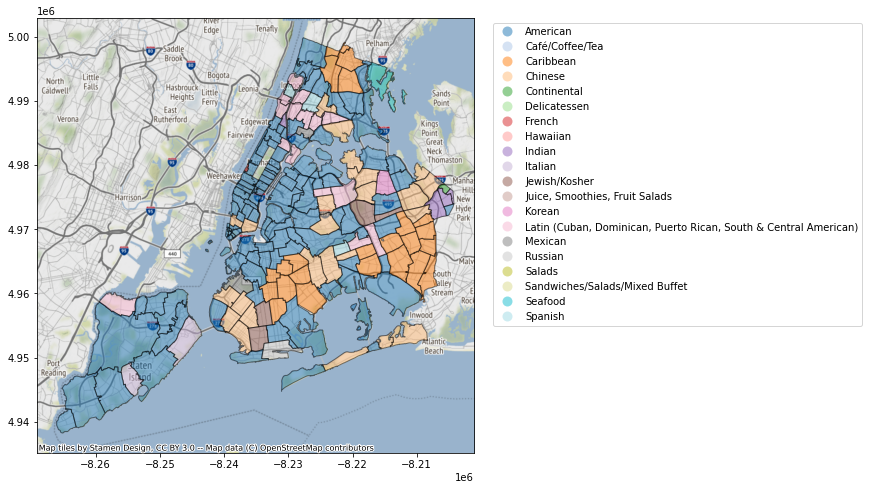

In [21]:
fig, ax = plt.subplots(figsize = (30,8))

zip_codes_merged.plot(column="Cuisine", legend = True, cmap = "tab20", ax = ax, legend_kwds = {"bbox_to_anchor" : (1.9,1)}, edgecolor = "k", alpha = 0.5)
ctx.add_basemap(ax)

# Create a dataframe with cuisine values in tact for merging zip

In [22]:
values_cuisines_zip = pd.DataFrame(df.groupby("ZIPCODE")["CUISINE DESCRIPTION"].value_counts())

In [23]:
values_cuisines_df = pd.DataFrame(list(zip(df.groupby("ZIPCODE")["CUISINE DESCRIPTION"].value_counts().index.to_list(), df.groupby("ZIPCODE")["CUISINE DESCRIPTION"].value_counts().values)))

In [24]:
values_cuisines_df[0] = values_cuisines_df[0].astype(str)

In [25]:
values_cuisines_df['ZIPCODE'], values_cuisines_df['CUISINE'] = values_cuisines_df[0].str.split(' ', 1).str

<ipython-input-25-614bc6f2e5a9>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  values_cuisines_df['ZIPCODE'], values_cuisines_df['CUISINE'] = values_cuisines_df[0].str.split(' ', 1).str


In [26]:
values_cuisines_df["ZIPCODE"] = values_cuisines_df["ZIPCODE"].replace("',", "", regex=True)
values_cuisines_df["ZIPCODE"] = values_cuisines_df["ZIPCODE"].replace("\('", "", regex=True)

In [27]:
values_cuisines_df["CUISINE"] = values_cuisines_df["CUISINE"].replace("'", "", regex=True)
values_cuisines_df["CUISINE"] = values_cuisines_df["CUISINE"].replace("\)", "", regex=True)

In [28]:
values_cuisines_df = values_cuisines_df.rename(columns = {1 : "CUISINE VALUES"})

In [29]:
values_cuisines_df = values_cuisines_df.drop(axis = 1, columns = 0 )

In [30]:
values_cuisines_df = values_cuisines_df.pivot("ZIPCODE", "CUISINE", "CUISINE VALUES")

In [31]:
values_cuisines_zip = pd.merge(zip_codes, values_cuisines_df, on='ZIPCODE')

In [32]:
values_cuisines_zip.head(2)

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   

  CTY_FIPS                   URL  ...  Soups & Sandwiches  Southwestern  \
0      081  http://www.usps.com/  ...                 NaN           NaN   
1      047  http://www.usps.com/  ...                 NaN           NaN   

  Spanish  Steak  Tapas  Tex-Mex  Thai  Turkish  Vegetarian  \
0     NaN    NaN    NaN      NaN   NaN      NaN         NaN   
1    22.0    NaN   15.0      NaN   NaN      NaN        27.0   

   Vietnamese/Cambodian/Malaysia  
0                            NaN  
1                            NaN  

[2 rows x 97 columns]

In [33]:
values_cuisines_zip.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'Afghan', 'African', 'American', 'Armenian', 'Asian',
       'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue',
       'Basque', 'Bottled beverages, including water, sodas, juices, etc.',
       'Brazilian', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean',
       'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese',
       'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen',
       'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian',
       'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek',
       'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels',
       'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian',
       'Irish', 'Italian', 'Japanese', 'Jewish/Kosher',
       'Juice, Smoothies, Fruit Salads', 'Korean',
       'Latin

# Look into the numbers of restaurants per area

In [34]:
zip_codes_count_restaurants = pd.DataFrame(df.groupby("ZIPCODE")["CAMIS"].count())

In [35]:
zip_codes_merged_count = gpd.GeoDataFrame(pd.merge(zip_codes, zip_codes_count_restaurants, on='ZIPCODE'))

In [36]:
zip_codes_merged_count["Restaurants/Pop"] = zip_codes_merged_count["CAMIS"] / zip_codes_merged_count["POPULATION"]

In [37]:
zip_codes_merged_count = zip_codes_merged_count.replace([np.inf, -np.inf], np.nan)
zip_codes_merged_count = zip_codes_merged_count.dropna()

In [38]:
zip_codes_merged_count["CAMIS"] = zip_codes_merged_count["CAMIS"].astype(int)

In [43]:
zip_codes_merged_count.crs = {'init' :'epsg:4326'}
zip_codes_merged_count = zip_codes_merged_count.to_crs(epsg=3857)

C:\Users\Kevin\Anaconda3\envs\geodata\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


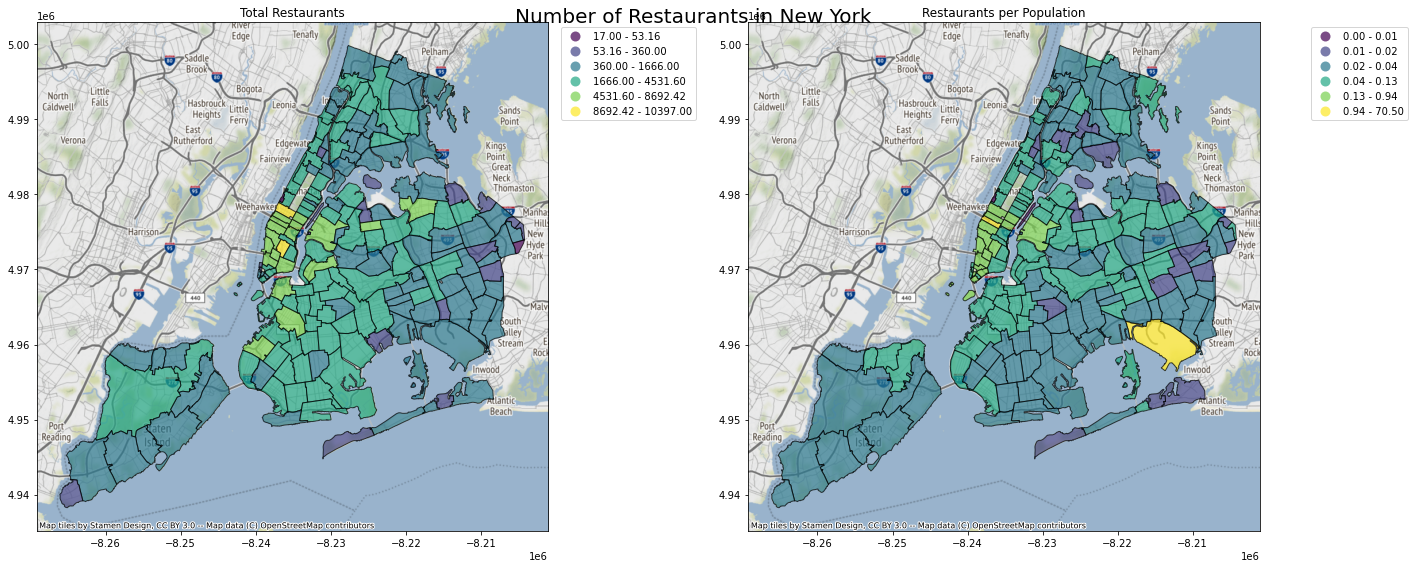

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))


zip_codes_merged_count.plot(column = "CAMIS", scheme = "Percentiles", legend = True, ax = ax1, legend_kwds = {"bbox_to_anchor" : (1.3,1)}, edgecolor = "k", alpha = 0.7)
ax1.set_title("Total Restaurants")
ctx.add_basemap(ax1)


zip_codes_merged_count.plot(column = "Restaurants/Pop", scheme = "Percentiles", legend = True, ax = ax2, legend_kwds = {"bbox_to_anchor" : (1.3,1)}, edgecolor = "k", alpha = 0.7)
ax2.set_title("Restaurants per Population")
ctx.add_basemap(ax2)

fig.suptitle('Number of Restaurants in New York', fontsize=20)
plt.tight_layout()
plt.show()

# Create Hexagons

In [47]:
# This code is retrieved from this notebook: https://github.com/willgeary/covid-nyc-dasymetric-map/blob/master/notebook.ipynb

from h3 import h3
import folium
import shapely.geometry

# Creating an H3 Hexagon Grid
def create_hexgrid(polygon, hex_res, geometry_col='geometry', map_zoom=12, buffer=0.000,
                   stroke_weight=0.5, stroke_color='blue', plot=True):
    """ Takes in a geopandas geodataframe, the desired resolution, the specified geometry column
        and some map parameters to create a hexagon grid (and potentially plot the hexgrid
    """
    centroid = list(polygon.centroid.values[0].coords)[0]
    fol_map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=map_zoom,
                         tiles='cartodbpositron')

    # Explode multipolygon into individual polygons
    exploded = polygon.explode().reset_index(drop=True)

    # Master lists for geodataframe
    hexagon_polygon_list = []
    hexagon_geohash_list = []

    # For each exploded polygon
    for poly in exploded[geometry_col].values:

        # Reverse coords for original polygon
        coords = list(poly.exterior.coords)
        reversed_coords = []
        for i in coords:
            reversed_coords.append([i[1], i[0]])

        # Reverse coords for buffered polygon
        buffer_poly = poly.buffer(buffer)
        buffer_coords = list(buffer_poly.exterior.coords)
        reversed_buffer_coords = []
        for i in buffer_coords:
            reversed_buffer_coords.append([i[1], i[0]])

        # Format input to the way H3 expects it
        aoi_input = {'type': 'Polygon', 'coordinates': [reversed_buffer_coords]}

        # Add polygon outline to map
        outline = reversed_coords
        outline.append(outline[0])
        outline = folium.PolyLine(locations=outline, weight=1, color='black')
        fol_map.add_child(outline)

        # Generate list geohashes filling the AOI
        geohashes = list(h3.polyfill(aoi_input, hex_res))

        # Generate hexagon polylines for Folium
        polylines = []
        lat = []
        lng = []
        for geohash in geohashes:
            polygons = h3.h3_set_to_multi_polygon([geohash], geo_json=False)
            outlines = [loop for polygon in polygons for loop in polygon]
            polyline = [outline + [outline[0]] for outline in outlines][0]
            lat.extend(map(lambda x: x[0], polyline))
            lng.extend(map(lambda x: x[1], polyline))
            polylines.append(polyline)
            hexagon_geohash_list.append(geohash)

        # Add the hexagon polylines to Folium map
        for polyline in polylines:
            my_polyline = folium.PolyLine(locations=polyline, weight=stroke_weight,
                                          color=stroke_color)
            fol_map.add_child(my_polyline)

        # Generate hexagon polygons for Shapely
        for geohash in geohashes:
            polygons = h3.h3_set_to_multi_polygon([geohash], geo_json=True)
            outlines = [loop for polygon in polygons for loop in polygon]
            polyline_geojson = [outline + [outline[0]] for outline in outlines][0]
            hexagon_polygon_list.append(shapely.geometry.Polygon(polyline_geojson))

    if plot:
        display(fol_map)

    # Create a geodataframe containing the hexagon geometries and hashes
    hexgrid_gdf = gpd.GeoDataFrame()
    hexgrid_gdf['geometry'] = hexagon_polygon_list
    id_col_name = 'hex_id_' + str(hex_res)
    hexgrid_gdf[id_col_name] = hexagon_geohash_list
    hexgrid_gdf.crs = {'init' :'epsg:4326'}

    # Drop duplicate geometries
    geoms_wkb = hexgrid_gdf["geometry"].apply(lambda geom: geom.wkb)
    hexgrid_gdf = hexgrid_gdf.loc[geoms_wkb.drop_duplicates().index]

    return hexgrid_gdf

In [ ]:
hexagons = create_hexgrid(zip_codes_merged, hex_res = 8, buffer=0.002, plot=False)

In [ ]:
hexagons = hexagons.reset_index()

In [ ]:
hexagons.plot()

# Use Tobler to interpolate the areas to hexagon

In [ ]:
from tobler.area_weighted import *
# from tobler import harmonize
import tobler

In [ ]:
values_cuisines_zip.crs = zip_codes_merged_count.crs = hexagons.crs = {'init': 'epsg:4326'}

In [ ]:
pop_food_columns = ["POPULATION", 'Afghan', 'African', 'American', 'Armenian', 'Asian',
       'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue',
       'Basque', 'Bottled beverages, including water, sodas, juices, etc.',
       'Brazilian', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean',
       'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese',
       'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen',
       'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian',
       'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek',
       'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels',
       'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian',
       'Irish', 'Italian', 'Japanese', 'Jewish/Kosher',
       'Juice, Smoothies, Fruit Salads', 'Korean',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American',
       'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan',
       'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Other', 'Pakistani',
       'Pancakes/Waffles', 'Peruvian', 'Pizza', 'Pizza/Italian', 'Polish',
       'Portuguese', 'Russian', 'Salads', 'Sandwiches',
       'Sandwiches/Salads/Mixed Buffet', 'Scandinavian', 'Seafood',
       'Soul Food', 'Soups', 'Soups & Sandwiches', 'Southwestern', 'Spanish',
       'Steak', 'Tapas', 'Tex-Mex', 'Thai', 'Turkish', 'Vegetarian',
       'Vietnamese/Cambodian/Malaysia']

food_columns = ['Afghan', 'African', 'American', 'Armenian', 'Asian',
       'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue',
       'Basque', 'Bottled beverages, including water, sodas, juices, etc.',
       'Brazilian', 'Café/Coffee/Tea', 'Cajun', 'Californian', 'Caribbean',
       'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese',
       'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen',
       'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian',
       'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek',
       'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels',
       'Ice Cream, Gelato, Yogurt, Ices', 'Indian', 'Indonesian', 'Iranian',
       'Irish', 'Italian', 'Japanese', 'Jewish/Kosher',
       'Juice, Smoothies, Fruit Salads', 'Korean',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American',
       'Mediterranean', 'Mexican', 'Middle Eastern', 'Moroccan',
       'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Other', 'Pakistani',
       'Pancakes/Waffles', 'Peruvian', 'Pizza', 'Pizza/Italian', 'Polish',
       'Portuguese', 'Russian', 'Salads', 'Sandwiches',
       'Sandwiches/Salads/Mixed Buffet', 'Scandinavian', 'Seafood',
       'Soul Food', 'Soups', 'Soups & Sandwiches', 'Southwestern', 'Spanish',
       'Steak', 'Tapas', 'Tex-Mex', 'Thai', 'Turkish', 'Vegetarian',
       'Vietnamese/Cambodian/Malaysia']

In [ ]:
result_area_cuisine = tobler.area_weighted.area_interpolate(values_cuisines_zip,
                                       hexagons, extensive_variables=pop_food_columns)

In [ ]:
hexagons = hexagons.reset_index()

In [ ]:
hexagons[pop_food_columns] = result_area_cuisine[pop_food_columns]

In [ ]:
def get_cuisine(row):
#     print(row)
    return(row[food_columns].astype(float).idxmax(axis = 1))

In [ ]:
hexagons["CUISINE"] = hexagons.apply(lambda x: get_cuisine(x), axis = 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey = True, sharex = True, figsize = (14, 15))

zip_codes_merged.plot(column="Cuisine", legend = True, cmap = "tab20", ax = ax1, legend_kwds = {"bbox_to_anchor" : (1.6,1)})
ax1.set_title("By ZIP Code")

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')

hexagons.plot(column="CUISINE", legend = True, cmap = "tab20", ax = ax2, legend_kwds = {"bbox_to_anchor" : (1.6,1)})
ax2.set_title("Dominating New York Cuisine By Hexagon")

# fig.title('This is a somewhat long figure title', fontsize=16)
fig.suptitle('New York Cuisines', fontsize=20, y = 1.03)
fig.tight_layout()
plt.savefig("#RestaurantsNY-CUISINE.png")

extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('#RestaurantsNY-CUISINE-hexagon.png', bbox_inches=extent.expanded(2.5, 1.1))

plt.show()

In [ ]:
result_area = tobler.area_weighted.area_interpolate(zip_codes_merged_count,
                                       hexagons, extensive_variables=["POPULATION", "CAMIS"])

In [ ]:
hexagons["interpolated_population"] = result_area["POPULATION"].astype(int)
hexagons["interpolated_restaurants"] = result_area["CAMIS"].astype(int)
hexagons["interpolated_rest_div_pop"] = (hexagons["interpolated_restaurants"] / hexagons["interpolated_population"]).astype(float)

In [ ]:
hexagons = hexagons.reset_index(drop = True)
hexagons = hexagons.replace([np.inf, -np.inf], np.nan)
hexagons = hexagons.dropna()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (20, 8))

zip_codes_merged_count.plot(column = "CAMIS", scheme = "Percentiles", legend = True, ax = ax1, legend_kwds = {"bbox_to_anchor" : (1.4,1)})
ax1.set_title("By ZIP Code")

hexagons.plot(column = "interpolated_restaurants", scheme = "Percentiles", legend = True, ax = ax2, legend_kwds = {"bbox_to_anchor" : (1.4,1)})
ax2.set_title("By Hexagon")

# fig.title('This is a somewhat long figure title', fontsize=16)
fig.suptitle('Number of Restaurants in New York', fontsize=20)
fig.tight_layout()
plt.savefig("#RestaurantsNY.png")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 8))


zip_codes_merged_count.plot(column = "Restaurants/Pop", scheme = "Percentiles", legend = True, ax = ax1, legend_kwds = {"bbox_to_anchor" : (1.4,1)})
ax1.set_title("By ZIP Code")

hexagons.plot(column = "interpolated_rest_div_pop", scheme = "Percentiles", legend = True, ax = ax2, legend_kwds = {"bbox_to_anchor" : (1.4,1)})
ax2.set_title("By Hexagon")

fig.suptitle('Number of Restaurants divided by population in New York', fontsize=20)
plt.tight_layout()
plt.savefig("#RestaurantsNYdivPop.png")
plt.show()